In [1]:
import pickle
from tqdm.auto import tqdm
import numpy as np

from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, confusion_matrix

import torch
import torch.nn.functional as F
from torch.optim import Adam

import matplotlib.pyplot as plt

import INN

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [3]:
train_dataset = datasets.MNIST(root='../../mnist_data/', train=True, download=False)
test_dataset = datasets.MNIST(root='../../mnist_data/', train=False, download=False)

In [4]:
X_train = train_dataset.data.view(-1, 28*28)
X_test = test_dataset.data.view(-1, 28*28)

y_train = train_dataset.targets
y_test = test_dataset.targets

In [5]:
sc_X_train = StandardScaler()
X_train_scaled = torch.Tensor(sc_X_train.fit_transform(X_train)).to(device)
X_test_scaled = torch.Tensor(sc_X_train.transform(X_test)).to(device)

y_train = F.one_hot(y_train).to(device).type(torch.float32)
y_test = F.one_hot(y_test)

In [7]:
loss_weights = {
    'bce_factor': 5,
    'dvg_factor': 1,
    'logdet_factor': 1,
    'rcst_factor': 10
}

In [8]:
batch_size = 64
n_epochs = 16

In [9]:
inn = INN.INN(X_train_scaled.size(1), y_train.size(1), n_blocks=5, coupling_network_layers=[512] * 2, device=device).to(device)

In [10]:
loss_history = inn.fit(X_train_scaled, y_train, n_epochs=n_epochs, batch_size=batch_size, optimizer=Adam(inn.parameters(), lr=1e-4), loss_weights=loss_weights, verbose=2)

Epoch 15: 100%|██████████| 937/937 [00:18<00:00, 50.01it/s, batch=936/937, weighted_loss=-730.288, bce=+0.804, dvg=+584.322, rcst=+0.336, logdet=-1321.989]


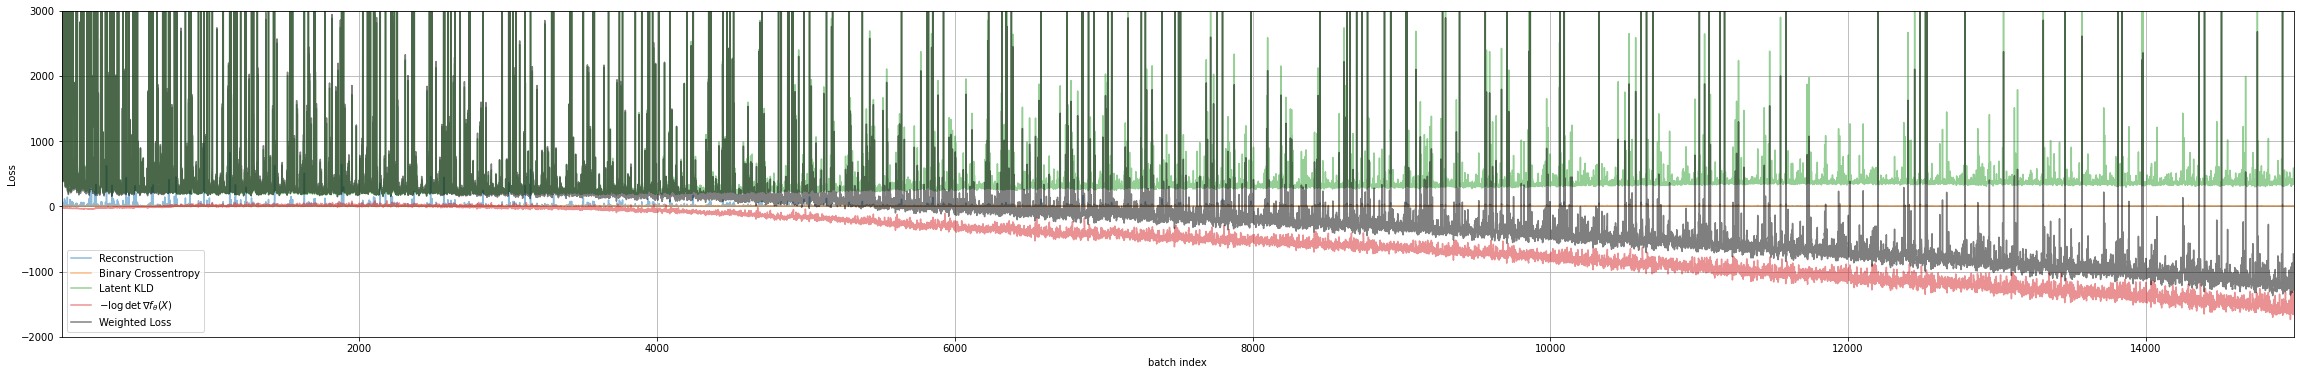

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(40, 6))

ax.plot(loss_history['rcst'], label='Reconstruction', alpha=0.5)
ax.plot(loss_history['bce'], label='Binary Crossentropy', alpha=0.5)
ax.plot(loss_history['dvg'], label='Latent KLD', alpha=0.5)
ax.plot(loss_history['logdet'], label=r'$-\log \det \nabla f_{\theta}(X)$', alpha=0.5)
ax.plot(loss_history['weighted_loss'], label='Weighted Loss', color='black', alpha=0.5)

ax.set_xlim(1, 1+len(loss_history['rcst'])); ax.set_ylim(-2000, 3000); 
ax.set_xlabel('batch index'); ax.set_ylabel('Loss'); ax.grid()
ax.legend();

In [12]:
inn.eval()

y_pred = np.empty((0, 10))
z_pred = np.empty((0, 774))
for i in tqdm(range(int(np.ceil(len(X_test_scaled) / batch_size)))):
    y_pred_new, z_pred_new = inn.forward(X_test_scaled[i * batch_size: (i+1) * batch_size])
    y_pred = np.concatenate([y_pred, y_pred_new.detach().cpu().numpy()], axis=0)
    z_pred = np.concatenate([z_pred, z_pred_new.detach().cpu().numpy()], axis=0)

100%|██████████| 157/157 [00:01<00:00, 127.71it/s]


In [13]:
# print(f'binary cross-entropy: {np.round(log_loss(y_test.cpu().numpy(), y_pred), 4)}')
# print(f'brier loss: {brier_score_loss(y_test, y_pred).round(4)}')
print(f'accuracy: {np.mean(np.argmax(y_pred, axis=1) == y_test.cpu().numpy().argmax(axis=1)).round(4)}')
# print('confusion matrix:')
# print(confusion_matrix(y_test, y_pred > 0.5))
# print()

accuracy: 0.6672


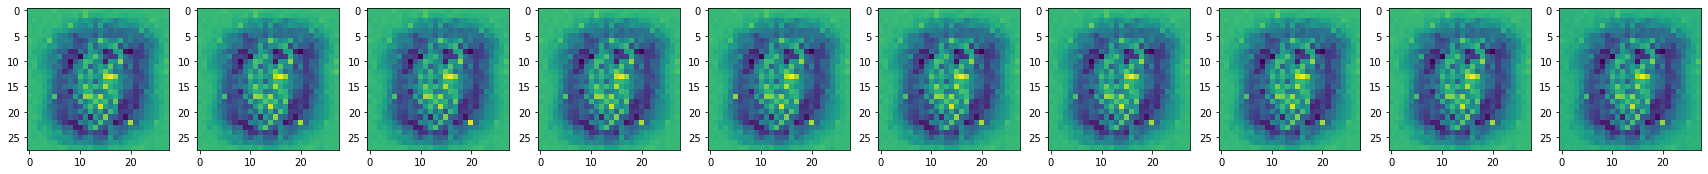

In [14]:
y_sample = F.one_hot(torch.arange(10)).to(device)
z_sample = torch.zeros((y_sample.size(0), 28*28-10)).to(device)

x_rec = inn.inverse(y_sample, z_sample).detach().cpu().numpy()

fig, ax = plt.subplots(1, 10, figsize=(30, 6))
for i in range(10):
    ax[i].imshow(x_rec[i].reshape(28, 28))